## imports/installations

In [ ]:
%pip install transformers datasets
%pip install groq
%pip install textstat
%pip install ujson
%pip install sentence-transformers
%pip install typing_extensions==4.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.5

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sentence_transformers import SentenceTransformer
import io
import os
import time
import pickle
import torch
from tqdm import tqdm
import numpy as np
from google.colab import drive
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
import random
import requests
import json
from datasets import load_dataset
from groq import Groq
import torch.nn.functional as F
import textstat
import matplotlib.pyplot as plt
drive.mount('/content/drive')



import sys
import ujson as json
import re
import string
from collections import Counter
from collections import defaultdict

Mounted at /content/drive


## Fill in this cell with your file paths

In [ ]:
trivia_corpus_path = ""
trivia_queries_path = ""
trivia_qrels_path = ""
corpus_embeddings_path = ""
corpus_ids_path = ""
gold_truth_path = ""
classifier_model_path = ""
hotpot_prompt_path = ""


## Load data

In [ ]:
from datasets import load_from_disk
# # Load the dataset from the saved directory
# triviaqa = load_from_disk(data_path)

Loading dataset from disk:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
import hashlib
def create_corpus(dataset):
    corpus = {}
    for item in dataset:
        search_results = item.get('search_results', {})
        descriptions = search_results.get('description', [])
        titles = search_results.get('title', [])

        for i in range(len(descriptions)):
            doc_id = hashlib.md5(descriptions[i].encode()).hexdigest()  # Create a unique ID
            if doc_id not in corpus:
                corpus[doc_id] = {
                    "title": titles[i] if i < len(titles) else "",  # Handle missing titles
                    "text": descriptions[i]
                }
    return corpus

def create_queries(dataset):
    queries = {}
    for i, item in enumerate(dataset):
        query_id = item['question_id']  # Use the original question ID from the dataset
        queries[query_id] = item['question']
    return queries

def create_qrels(dataset, corpus):
    qrels = {}
    for i, item in enumerate(dataset):
        query_id = item['question_id']
        qrels[query_id] = {}
        search_results = item.get('search_results', {})
        descriptions = search_results.get('description', [])

        for desc in descriptions:
            doc_id = hashlib.md5(desc.encode()).hexdigest()
            if doc_id in corpus:
                qrels[query_id][doc_id] = 1
    return qrels

In [ ]:
print("loading corpus, queries, qrels")

with open(trivia_corpus_path, 'rb') as file:
    corpus = pickle.load(file)

with open(trivia_queries_path, 'rb') as file:
    queries = pickle.load(file)

with open(trivia_qrels_path, 'rb') as file:
    qrels = pickle.load(file)

print(f"Corpus size: {len(corpus)}")
print(f"Queries size: {len(queries)}")
print(f"Qrels size: {len(qrels)}")

Corpus size: 102180
Queries size: 11313
Qrels size: 11313


## Evaluation functions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def precision_at_k(ranking_scores, relevant_docs, k):
    retrieved_docs = [doc_id for doc_id, _ in ranking_scores[:k]]
    relevant_retrieved_docs = len(set(retrieved_docs) & relevant_docs)
    return relevant_retrieved_docs / k

def recall_at_k(ranking_scores, relevant_docs, k):
    retrieved_docs = [doc_id for doc_id, _ in ranking_scores[:k]]
    relevant_retrieved_docs = len(set(retrieved_docs) & relevant_docs)
    return relevant_retrieved_docs / len(relevant_docs) if relevant_docs else 0

def ndcg_at_k(ranking_scores, relevant_docs, k):
    dcg = 0.0
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(relevant_docs), k))])

    if idcg == 0:  # Prevent division by zero
      return 0.0

    for i, (doc_id, score) in enumerate(ranking_scores[:k]):
        if doc_id in relevant_docs:
            dcg += 1.0 / np.log2(i + 2)
    return dcg / idcg

def load_classifier_model():
    global classifier_model_path

    # Detect the device
    print(f'Using device: {device}')

    # Load the classifier model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    # classifier_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    with open(classifier_model_path, 'rb') as f:
        classifier_model = pickle.load(f)

    classifier_model.to(device)

    return classifier_model, tokenizer


def create_corpus_embeddings(corpus, model):
    global corpus_embeddings_path, corpus_ids_path
    corpus_ids, corpus_embeddings = encode_corpus(corpus, model)
    corpus_embeddings_np = corpus_embeddings.cpu().numpy()

    # save_embeddings(corpus_ids, corpus_embeddings, "corpus_embeddings")
    np.save(corpus_embeddings_path, np.array(corpus_embeddings_np))
    np.save(corpus_ids_path, np.array(corpus_ids))


def create_query_embeddings(queries, model):
    query_ids, query_embeddings = encode_queries(queries, model)
    save_embeddings(query_ids, query_embeddings, "query_embeddings")

def create_embeddings(corpus, queries, model):
    corpus_ids, corpus_embeddings = encode_corpus(corpus, model)
    query_ids, query_embeddings = encode_queries(queries, model)
    save_embeddings(corpus_ids, corpus_embeddings, "corpus_embeddings")
    save_embeddings(query_ids, query_embeddings, "query_embeddings")

def load_embedding_model(model_name='all-MiniLM-L6-v2'):
    return SentenceTransformer(model_name)


def calculate_linguistic_complexity(query):
    # Calculate Flesch-Kincaid Grade Level and Dale-Chall Readability Score
    fk_score = textstat.flesch_kincaid_grade(query)
    dc_score = textstat.dale_chall_readability_score(query)

    # Normalize the scores to a common scale or use them directly
    # Here, I'm averaging them, but you can apply your logic
    complexity_score = (fk_score + dc_score) / 2

    return complexity_score

def encode_corpus(corpus, model, batch_size=16):
    corpus_ids = list(corpus.keys())
    corpus_texts = [doc['text'] for doc in corpus.values()]

    corpus_embeddings = []
    for i in tqdm(range(0, len(corpus_texts), batch_size), desc="Encoding Corpus"):
        batch_texts = corpus_texts[i:i + batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
        corpus_embeddings.append(batch_embeddings.cpu())  # Move to CPU immediately
        torch.cuda.empty_cache()  # Clear GPU memory

    corpus_embeddings = torch.cat(corpus_embeddings, dim=0)
    return corpus_ids, corpus_embeddings

def encode_queries(queries, model, batch_size=32):
    query_ids = list(queries.keys())
    query_texts = list(queries.values())
    query_embeddings = []
    for i in tqdm(range(0, len(query_texts), batch_size), desc="Encoding Queries"):
        batch_texts = query_texts[i:i + batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
        query_embeddings.append(batch_embeddings)
    query_embeddings = torch.cat(query_embeddings, dim=0)
    return query_ids, query_embeddings

def save_embeddings(ids, embeddings, file_prefix):
    np.save(f"./{file_prefix}_ids.npy", np.array(ids))
    np.save(f"./{file_prefix}_embeddings.npy", embeddings.cpu().numpy())

def load_embeddings(file_prefix):
    ids = np.load(f"./{file_prefix}_ids.npy", allow_pickle=True).tolist()
    embeddings = torch.tensor(np.load(f"./{file_prefix}_embeddings.npy"))
    return ids, embeddings

def load_corpus_embeddings_for_evaluation():
    print("Loading embeddings...")
    corpus_ids, corpus_embeddings = load_embeddings("corpus_embeddings")
    print("Embeddings loaded.")
    return corpus_ids, corpus_embeddings

def load_query_embeddings_for_evaluation():
    print("Loading embeddings...")
    query_ids, query_embeddings = load_embeddings("query_embeddings")
    print("Embeddings loaded.")
    return query_ids, query_embeddings

def save_results(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_results(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def retrieve(corpus_ids, corpus_embeddings, query_ids, query_embeddings, top_k):
    results = {}
    for i, query_embedding in tqdm(enumerate(query_embeddings), desc="Retrieving Documents", total=len(query_embeddings)):
        scores = torch.matmul(query_embedding, corpus_embeddings.T)
        sorted_indices = torch.argsort(scores, descending=True)[:top_k]
        results[query_ids[i]] = [(corpus_ids[idx], scores[idx].item()) for idx in sorted_indices]
    return results

def retrieve_single_query_complex(corpus_ids, corpus_embeddings, query_id, query_embedding, top_k, similarity_threshold=0.5):

    scores = torch.matmul(query_embedding, corpus_embeddings.T)
    sorted_indices = torch.argsort(scores, descending=True)

    top_results = []
    for idx in sorted_indices:
        if idx >= len(corpus_ids):
            print(f"Index {idx} is out of bounds for corpus_ids with length {len(corpus_ids)}")
            continue

        score = scores[idx].item()
        if score >= similarity_threshold:
            top_results.append((corpus_ids[idx], score))
            if len(top_results) == top_k:
                break
        else:
            break

       # Ensure at least one document is retrieved
    if len(top_results) == 0:
        # Retrieve the top-ranked document even if it doesn't meet the similarity threshold
        valid_index = sorted_indices[sorted_indices < len(corpus_ids)][0]
        top_results.append((corpus_ids[valid_index], scores[valid_index].item()))

    return top_results

def retrieve_single_query_simple(corpus_ids, corpus_embeddings, query_id, query_embedding, top_k, similarity_threshold=0.5):

    scores = torch.matmul(query_embedding, corpus_embeddings.T)

    sorted_indices = torch.argsort(scores, descending=True)[:top_k]

    top_results = [(corpus_ids[idx], scores[idx].item()) for idx in sorted_indices]

    return top_results

def calculate_linguistic_complexity(query):
    # Calculate Flesch-Kincaid Grade Level and Dale-Chall Readability Score
    fk_score = textstat.flesch_kincaid_grade(query)
    dc_score = textstat.dale_chall_readability_score(query)

    # Normalize the scores to a common scale or use them directly
    complexity_score = (fk_score + dc_score) / 2

    return complexity_score

# os.environ["GROQ_API_KEY"] = "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"


def format_input(passages_texts, question):
    formatted_passages = ""
    for i, passage in enumerate(passages_texts, 1):
        formatted_passages += f"Document [{i}]: {passage}\n"
    formatted_input = f"{formatted_passages}\nQuestion: {question}\nAnswer:"
    return formatted_input

def generate_answer(question, passages_texts):
    global hotpot_prompt_path
    with open(hotpot_prompt_path, 'r') as file:
        prompt_template = file.read()

    formatted_passages = ""
    for i, passage in enumerate(passages_texts, 1):
        formatted_passages += f"Document [{i}] {passage}\n"

    input_text = prompt_template.format(search_results=formatted_passages, question=question)

    client = Groq(api_key="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")

    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": input_text,
        }
    ],
    model="llama3-8b-8192",
    )

    answer = chat_completion.choices[0].message.content
    return answer

    # with open('./hotpotqa_prompt.txt', 'r') as file:
    #     prompt_template = file.read()

    # formatted_passages = ""
    # for i, passage in enumerate(passages_texts, 1):
    #     formatted_passages += f"Document [{i}] {passage}\n"

    # input_text = prompt_template.format(search_results=formatted_passages, question=question)

    # client = OpenAI(
    #   base_url="https://openrouter.ai/api/v1",
    #   api_key="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",
    # )

    # completion = client.chat.completions.create(
    #   model="microsoft/phi-3-mini-128k-instruct",
    #   messages=[
    #     {
    #       "role": "user",
    #       "content": input_text,
    #     },
    #   ],
    # )

    # if completion is None or not completion.choices or not completion.choices[0].message:
    #     # Handle the error, for example, by returning a default value or raising an exception
    #     raise ValueError("Invalid completion response received")

    # answer = completion.choices[0].message.content
    # return answer

def save_answers_to_json(generated_answers, file_path, append=False):
    """Save the generated answers to a JSON file."""
    if append and os.path.exists(file_path):
        # Load existing answers and update with new ones
        with open(file_path, 'r+') as file:
            existing_answers = json.load(file)
            existing_answers.update(generated_answers)
            file.seek(0)
            json.dump(existing_answers, file, indent=4)
    else:
        # Save new answers
        with open(file_path, 'w') as file:
            json.dump(generated_answers, file, indent=4)

def map_jsons(generated_answers_filename, gold_truth_answers_filename, title):
    # Load JSON data (assuming this is in a file named 'generated_answers.json')
    with open(generated_answers_filename, 'r') as file:
        generated_answers = json.load(file)

    # Load JSONL data (assuming this is in a file named 'gold_answers.jsonl')
    id_to_gold_answer = {}
    with open(gold_truth_answers_filename, 'r') as file:
        for line in file:
            item = json.loads(line)
            id_to_gold_answer[item["_id"]] = item["metadata"]["answer"]

    # Update the first JSON object with gold truth answers
    for key in generated_answers:
        if key in id_to_gold_answer:
            generated_answers[key] = {
                "generated_answer": generated_answers[key],
                "gold_truth_answer": id_to_gold_answer[key]
            }

    # Save the updated JSON data (assuming you want to save it to 'updated_answers.json')
    with open(f'./{title}_updated_answers.json', 'w') as file:
        json.dump(generated_answers, file, indent=4)

def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def update_answer(metrics, prediction, gold):
    em = exact_match_score(prediction, gold)
    f1, prec, recall = f1_score(prediction, gold)
    metrics['em'] += float(em)
    metrics['f1'] += f1
    metrics['prec'] += prec
    metrics['recall'] += recall
    return em, prec, recall

def eval(prediction_file, title):
    with open(prediction_file) as f:
        data = json.load(f)

    metrics = {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0}
    N = len(data)

    for cur_id, values in data.items():
        generated_answer = values['generated_answer']
        gold_truth_answer = values['gold_truth_answer']

        em, prec, recall = update_answer(metrics, generated_answer, gold_truth_answer)

    for k in metrics.keys():
        metrics[k] /= N

    with open(f'./metrics_{title}.json', 'w') as metrics_file:
        json.dump(metrics, metrics_file, indent=4)

    print(metrics)

def random_sampling(queries, sample_size):
    # Ensure sample size is not larger than the available number of queries
    if sample_size > len(queries):
        sample_size = len(queries)

    # Randomly sample query IDs
    sampled_query_ids = random.sample(list(queries.keys()), sample_size)

    # Create a new dictionary with the sampled queries
    sampled_queries = {qid: queries[qid] for qid in sampled_query_ids}

    return sampled_queries


def compute_query_length(query):
    """Compute the length of the query."""
    return len(query)  # length based on number of characters


def stratified_sampling_length(queries, bin_size, sample_size_per_bin,):
    # Calculate the length of each query (in words)
    # query_lengths = {qid: len(query.split()) for qid, query in queries.items()}
    query_lengths = {qid: len(query) for qid, query in queries.items()}


    # Group queries by their length ranges
    bins = defaultdict(list)
    for qid, length in query_lengths.items():
        bin_range = (length - 1) // bin_size * bin_size + 1
        bins[bin_range].append(qid)

    # Print the number of bins and the word length ranges they contain
    # print(f"Number of bins: {len(bins)}")
    # print("Word length ranges and their respective number of queries:")
    for bin_range, qids in bins.items():
        bin_end = bin_range + bin_size - 1
        # print(f"Length {bin_range}-{bin_end} words: {len(qids)} queries")

    # Sample from each bin
    sampled_queries = {}
    for bin_range, qids in bins.items():
        if len(qids) > sample_size_per_bin:
            sampled_qids = random.sample(qids, sample_size_per_bin)
        else:
            sampled_qids = qids  # Take all if less than the sample size
        sampled_queries.update({qid: queries[qid] for qid in sampled_qids})

    return sampled_queries

def stratified_sample_by_supporting_docs(queries, qrels, bin_size=1, samples_per_bin=10):
    # Count the number of supporting documents for each query
    query_support_count = {qid: len(qrels[qid]) for qid in queries.keys() if qid in qrels}

    # Check if query_support_count is empty
    if not query_support_count:
        raise ValueError("No queries have corresponding supporting documents in qrels.")

    # Determine the maximum number of supporting documents
    max_support_docs = max(query_support_count.values())

    # Create bins based on the bin_size
    bins = np.arange(0, max_support_docs + bin_size, bin_size)

    # Group queries by the number of supporting documents
    grouped_queries = {bin: [] for bin in bins}
    for qid, count in query_support_count.items():
        for b in bins:
            if b <= count < b + bin_size:
                grouped_queries[b].append(qid)
                break

    # Sample from each bin
    stratified_sample = {}
    for b in bins:
        queries_in_bin = grouped_queries[b]
        if len(queries_in_bin) > samples_per_bin:
            sampled_queries = random.sample(queries_in_bin, samples_per_bin)
        else:
            sampled_queries = queries_in_bin  # If there are fewer queries than samples_per_bin, take all

        # Add sampled queries to the dictionary
        stratified_sample.update({qid: queries[qid] for qid in sampled_queries})

    return stratified_sample


def cross_validation_sampling(queries, num_folds, sample_size):
    """Generate multiple folds of samples."""
    query_ids = list(queries.keys())
    kf = KFold(n_splits=num_folds)

    folds = []
    for train_index, test_index in kf.split(query_ids):
        fold = {qid: queries[qid] for qid in np.array(query_ids)[test_index]}
        folds.append(fold)

    return folds

def print_results_with_passages_and_answers(results, queries, corpus, qrels, max_entries=5):
    # Initialize a counter
    count = 0

    for query_id, passages in results.items():
        if count >= max_entries:
            break  # Exit the loop if the maximum number of entries has been printed

        # Retrieve the question text
        question_text = queries.get(query_id, "Unknown Question")

        # Retrieve the gold standard answer
        gold_answer = qrels.get(query_id, "No gold answer found")

        print(f"Question: {question_text}")
        print(f"Gold Answer: {gold_answer}")
        print("Retrieved Passages:")

        # Retrieve and print the passages
        for doc_id, score in passages:
            passage_text = corpus.get(doc_id, {}).get('text', "No passage found")
            print(f"Passage ID: {doc_id}")
            print(f"Score: {score}")
            print(f"Passage Text: {passage_text}")
            print("-" * 80)  # Separator for readability

        print("=" * 80)  # Separator between questions

        # Increment the counter
        count += 1


def evaluate_results_at_k(results, queries, corpus, top_k, qrels):
    precision_scores = []
    recall_scores = []
    ndcg_scores = []

    for query_id, ranking_scores in results.items():
        relevant_docs = set(qrels.get(query_id, {}))
        precision_scores.append(precision_at_k(ranking_scores, relevant_docs, top_k))
        recall_scores.append(recall_at_k(ranking_scores, relevant_docs, top_k))
        ndcg_scores.append(ndcg_at_k(ranking_scores, relevant_docs, top_k))

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_ndcg = np.mean(ndcg_scores)

    print(f"Average Precision@{top_k}: {avg_precision}")
    print(f"Average Recall@{top_k}: {avg_recall}")
    print(f"Average NDCG@{top_k}: {avg_ndcg}")

def evaluate_results_multiple_ks(results, queries, corpus, top_ks, qrels):
    for top_k in top_ks:
        evaluate_results_at_k(results, queries, corpus, top_k, qrels)


def load_existing_answers(file_path):
    """Load existing answers from a JSON file if it exists."""
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            return json.load(file)
    return {}

def generate_save_answers(results, queries, corpus, title, processed_queries=set()):
    os.environ["GROQ_API_KEY"] = "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"

    generated_answers_file = f'./{title}_generated_answers.json'
    print(f"Generating answers for {len(results)} queries")

    # Load existing generated answers to resume processing
    generated_answers = load_existing_answers(generated_answers_file)

    for query_id, passages in tqdm(results.items(), desc="Generating Answers", total=len(results)):
        if query_id in processed_queries or query_id in generated_answers:
            continue  # Skip already processed queries

        passages_text = [corpus[doc_id]['text'] for doc_id, _ in passages]
        generated_answer = generate_answer(queries[query_id], passages_text)
        generated_answers[query_id] = generated_answer

        # Save the generated answer to the JSON file immediately
        save_answers_to_json({query_id: generated_answer}, generated_answers_file, append=True)

        # Update processed queries
        processed_queries.add(query_id)

    return processed_queries


def map_jsons_new(generated_answers_filename, gold_truth_answers_filename, title):
    # Load the gold truth answers
    with open(gold_truth_answers_filename, 'r') as file:
        id_to_gold_answer = json.load(file)

    # Load generated answers
    with open(generated_answers_filename, 'r') as file:
        generated_answers = json.load(file)

    # Match and map the generated answers with the gold truth answers
    updated_answers = {}
    for query_id, generated_answer in generated_answers.items():
        gold_answer = id_to_gold_answer.get(query_id)
        if gold_answer:
            updated_answers[query_id] = {
                "generated_answer": generated_answer,
                "gold_truth_answer": gold_answer
            }
        else:
            # If no gold answer is found, just include the generated answer
            updated_answers[query_id] = {
                "generated_answer": generated_answer,
                "gold_truth_answer": None
            }

    # Save the mapped results
    output_filename = f'./{title}_updated_answers.json'
    with open(output_filename, 'w') as outfile:
        json.dump(updated_answers, outfile, indent=4)
    print(f"Updated answers saved to {output_filename}")

def get_results(corpus, queries, corpus_ids, corpus_embeddings, model, top_k):
    # corpus_ids, corpus_embeddings = load_embeddings("corpus_embeddings")
    query_ids, query_embeddings = load_embeddings("query_embeddings")
    start_time = time.time()
    results = retrieve(corpus_ids, corpus_embeddings, query_ids, query_embeddings, top_k)
    retrieval_time = time.time() - start_time
    print(f"Retrieval Time: {retrieval_time:.2f} seconds")
    print(f"Queries Processed per Second: {len(queries) / retrieval_time:.2f}")
    return results

def preprocess_question(question, tokenizer):
    # 'return_tensors' is correctly passed to the tokenizer, not the model
    inputs = tokenizer(question, return_tensors='pt', padding=True, truncation=True)
    return inputs

def classify_question(question, model, tokenizer):
    # Preprocess the question using the tokenizer
    inputs = preprocess_question(question, tokenizer)

    # Ensure inputs are moved to the same device as the model
    inputs = {key: val.to(model.device) for key, val in inputs.items()}

    # Perform inference without computing gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract logits and calculate probabilities
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)

    # Return the confidence scores for open-ended and not open-ended classes
    confidence_open_ended = probs[:, 1].item()
    confidence_not_open_ended = probs[:, 0].item()

    return confidence_open_ended, confidence_not_open_ended

def interpret_classification(query, model, tokenizer):
    # Classify the question to determine if it's open-ended
    confidence_open_ended, confidence_not_open_ended = classify_question(query, model, tokenizer)

    # Determine the classification based on the confidence scores
    if confidence_open_ended > confidence_not_open_ended:
        classification = 'Open-ended'
    else:
        classification = 'Not open-ended'

    return {
        'question': query,
        'classification': classification,
        'confidence_open_ended': confidence_open_ended,
        'confidence_not_open_ended': confidence_not_open_ended
    }

def calculate_linguistic_complexity(query):
    # Calculate Flesch-Kincaid Grade Level and Dale-Chall Readability Score
    fk_score = textstat.flesch_kincaid_grade(query)
    dc_score = textstat.dale_chall_readability_score(query)

    # Normalize the scores to a common scale or use them directly
    # Here, I'm averaging them, but you can apply your logic
    complexity_score = (fk_score + dc_score) / 2

    return complexity_score


def get_results_oe(queries, query_ids, query_embeddings, corpus_ids,
                   corpus_embeddings, corpus, retriever_model, classifier_model, classifier_tokenizer,
                   top_k):

    print("Retrieving for open-ended retrieval method...")
    classifier_model.eval()

    start_time = time.time()

    results = {}
    top_k_values = {}
    for i, (query_id, query_text, query_embedding) in tqdm(enumerate(zip(query_ids, queries.values(), query_embeddings)), desc="Retrieving Documents", total=len(queries)):

        # Classify the query
        classification = interpret_classification(query_text, classifier_model, classifier_tokenizer)
        classification_label = classification['classification']
        confidence_open_ended = classification['confidence_open_ended']
        confidence_not_open_ended = confidence_not_open_ended = classification['confidence_not_open_ended']

        ###### COMPLEXITY SCORE ONLY #####
        # # Calculate linguistic complexity
        complexity_score = calculate_linguistic_complexity(query_text)

        # Determine the number of documents to retrieve based on complexity score
        if complexity_score >= 12:
            top_k = 5  # very complex, retrieve less documents
        elif complexity_score >= 8 and complexity_score < 11:
            top_k = 7  # moderately complex, retrieve a moderate number of documents
        elif complexity_score < 8:
            top_k = 10  # simple, retrieve more documents



        ###### CLASSIFICATION + COMPLEXITY SCORE #######
        # Determine the number of documents to retrieve based on classification, confidence, and complexity
        # if classification_label == 'Open-ended':
        #     if confidence_open_ended > 0.8:
        #         top_k = 10 if complexity_score < 10 else 7  # High confidence, more docs if less complex
        #     elif confidence_open_ended > 0.6:
        #         top_k = 7 if complexity_score < 10 else 5   # Medium confidence, moderate docs
        #     else:
        #         top_k = 5 if complexity_score < 10 else 3   # Low confidence, fewer docs
        # else:
        #     if confidence_not_open_ended > 0.8:
        #         top_k = 3 if complexity_score < 10 else 5   # High confidence, fewer docs
        #     elif confidence_not_open_ended > 0.6:
        #         top_k = 5 if complexity_score < 10 else 7   # Medium confidence, moderate docs
        #     else:
        #         top_k = 7 if complexity_score < 10 else 10  # Low confidence, more docs


        ###### CLASSIFICATION ONLY #######
        # Determine the number of documents to retrieve based on classification and confidence
        # if classification_label == 'Open-ended':
        #     if confidence_open_ended > 0.8:
        #         top_k = 10  # High confidence, more docs if less complex
        #     elif confidence_open_ended > 0.6:
        #         top_k = 7   # Medium confidence, moderate docs
        #     else:
        #         top_k = 5   # Low confidence, fewer docs
        # else:
        #     if confidence_not_open_ended > 0.8:
        #         top_k = 3   # High confidence, fewer docs
        #     elif confidence_not_open_ended > 0.6:
        #         top_k = 5  # Medium confidence, moderate docs
        #     else:
        #         top_k = 7  # Low confidence, more docs

        # Retrieve relevant passages
        results[query_id] = retrieve_single_query_simple(corpus_ids, corpus_embeddings, query_id, query_embedding, top_k)
        top_k_values[query_id] = top_k  # Store the top_k value used

    end_time = time.time()
    retrieval_time = end_time - start_time

    print(f"Retrieval Time: {retrieval_time:.2f} seconds")
    print(f"Queries Processed per Second: {len(queries) / retrieval_time:.2f}")

    return results, top_k_values, retrieval_time

def evaluate_retrieval_system(type, corpus, queries, corpus_ids, corpus_embeddings, qrels, model, classifier_model, classifier_tokenizer, title, top_k):
    global corpus_ids_path, gold_truth_path
    # corpus_ids, corpus_embeddings = load_embeddings("corpus_embeddings")
    query_ids, query_embeddings = load_embeddings("query_embeddings")

    start_time = time.time()
    if type == "base-retrieval-system":
        results = get_results(corpus, queries, corpus_ids, corpus_embeddings, model, top_k)

        # Save retrieval results
        print("Saving retrieval results")
        save_results(f'./{title}_retrieval_results.pkl', results)
        print("Retrieval results saved")


        results = load_results(f'./{title}_retrieval_results.pkl')
        print("Retrieval results loaded")

        # Generate answers using LLM with a progress bar
        print("\n\nGenerating answers")
        os.environ["GROQ_API_KEY"] = "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"
        generate_save_answers(results, queries, corpus, title)
        print("Answers generated and saved")

        # Compare answers to gold truth
        print("Comparing answers to gold truth")
        map_jsons_new(f'./{title}_generated_answers.json', gold_truth_path, title)
        eval(f'./{title}_updated_answers.json', title)

        retrieval_time = time.time() - start_time
        print(f"Total Time for Retrieval System Evaluation: {retrieval_time:.2f} seconds")

    elif type == "open-ended-retrieval-system":
        results, top_k_values, _ = get_results_oe(queries, query_ids, query_embeddings, corpus_ids,
                                   corpus_embeddings, corpus,
                                   model, classifier_model, classifier_tokenizer, top_k)




        # Save top_k values
        print("Saving top_k values")
        save_results(f'./{title}_top_k_values.pkl', top_k_values)
        print("top_k values saved")

        top_k_values = load_results(f'./{title}_top_k_values.pkl')
        print("top-k values loaded")

        # Group queries by top_k and evaluate
        grouped_results = {}
        for query_id, passages in results.items():
            k = top_k_values[query_id]
            if k not in grouped_results:
                grouped_results[k] = {}
            grouped_results[k][query_id] = passages

        # Initialize a metrics dictionary to store results for each top_k
        all_metrics = {}

        # Evaluate each group separately
        for k, group_results in grouped_results.items():
            print(f"Evaluating for top-{k}...")
            evaluate_results_at_k(group_results, queries, corpus, k, qrels)

            # Generate answers and compare them to the gold truth for this group
            title_group = f"{title}_top{k}"
            generate_save_answers(group_results, queries, corpus, title_group)
            map_jsons(f'./{title_group}_generated_answers.json', gold_truth_path, title_group)
            eval(f'./{title_group}_updated_answers.json', title_group)

            # Load metrics for this group
            with open(f'./metrics_{title_group}.json', 'r') as metrics_file:
                metrics = json.load(metrics_file)

            # Add the number of queries analyzed for this top_k group
            metrics['num_queries'] = len(group_results)

            # Save metrics for this group
            all_metrics[k] = metrics

        # Optionally, save all metrics for later comparison
        with open(f'./metrics_{title}_all.json', 'w') as metrics_file:
            json.dump(all_metrics, metrics_file, indent=4)

        return all_metrics



def evaluation_pipeline(type, model, classifier_model, classifier_tokenizer, corpus, queries, qrels, corpus_embeddings, create_corpus_embeddings_flag, create_query_embeddings_flag, title):
    """
    Runs the evaluation pipeline with the specified sampling strategy.

    Parameters:
    - type: Type of retrieval system (e.g., 'base-retrieval-system', 'open-ended-retrieval-system')
    - model: The embedding model
    - corpus: The corpus of documents
    - queries: The set of queries
    - qrels: The ground truth answers
    - corpus_size: Number of documents to consider in the corpus
    - create_corpus_embeddings_flag: Flag to create corpus embeddings
    - create_query_embeddings_flag: Flag to create query embeddings
    - sampling_type: Type of sampling to use ('random', 'stratified')
    - num_bins: Number of bins for stratified sampling
    - sample_size_per_bin: Number of samples to take per bin in stratified sampling
    """
    qrels = {k: qrels[k] for k in queries.keys() if k in qrels}
    print("length of queries", len(queries))
    print("length of qrels", len(qrels))


    ks = [1, 3, 5, 10]

    if create_corpus_embeddings_flag:
        create_corpus_embeddings(corpus, model)
    if create_query_embeddings_flag:
        create_query_embeddings(queries, model)

    print("Loading embeddings")
    corpus_ids = np.load(corpus_ids_path, allow_pickle=True).tolist()
    # corpus_embeddings = torch.tensor(np.load("/Users/anjali/Imperial/dissertation/embeddings/corpus_embeddings5m.npy"))

    print("Embeddings loaded")
    # corpus_ids, corpus_embeddings = load_corpus_embeddings_for_evaluation()
    query_ids, query_embeddings = load_query_embeddings_for_evaluation()

    if type == "base-retriever":
        results = get_results(corpus, queries, model, top_k=10)
        evaluate_results_multiple_ks(results, queries, corpus, ks, qrels)
    elif type == "open-ended-retriever":
        classifier_model, classifier_tokenizer = load_classifier_model()
        results, _ = get_results_oe(queries, query_ids, query_embeddings, corpus_ids,
                                    corpus_embeddings, corpus, classifier_model, classifier_tokenizer,
                                    model, top_k=10)
        evaluate_results_multiple_ks(results, queries, corpus, ks, qrels)
    elif type == "base-retrieval-system":
        all_metrics = evaluate_retrieval_system(type, corpus, queries, corpus_ids, corpus_embeddings, qrels, model, classifier_model, classifier_tokenizer, title, top_k=10)
    elif type == "open-ended-retrieval-system":
        all_metrics = evaluate_retrieval_system(type, corpus, queries, corpus_ids, corpus_embeddings, qrels, model, classifier_model, classifier_tokenizer, title, top_k=10)


## Load embeddings, models

In [ ]:
corpus_embeddings = torch.tensor(np.load(corpus_embeddings_path))

model = load_embedding_model()
model.to(device='cuda')

# Detect the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the classifier model and tokenizer
classifier_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
with open(classifier_model_path, 'rb') as f:
    classifier_model = pickle.load(f)

classifier_model.to(device)
classifier_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Experiments

In [ ]:
base_title = "triviaqa_base_4000"
base_sample = random_sampling(queries, 4000)

## save random sample json
with open(f'{base_title}_sample.json', 'w') as f:
    json.dump(base_sample, f)
print(len(base_sample))

evaluation_pipeline("base-retrieval-system", model, classifier_model, classifier_tokenizer, corpus, base_sample, qrels, corpus_embeddings, False, True, base_title)




In [ ]:
complexity_title = "triviaqa_complexity_4000"
complexity_sample = random_sampling(queries, 4000)

## save random sample json
with open(f'{complexity_title}_sample.json', 'w') as f:
    json.dump(complexity_sample, f)
print(len(complexity_sample))

evaluation_pipeline("open-ended-retrieval-system", model, classifier_model, classifier_tokenizer, corpus, complexity_sample, qrels, corpus_embeddings, False, True, complexity_title)




In [ ]:
classification_title = "triviaqa_classification_4000"
classification_sample = random_sampling(queries, 4000)

## save random sample json
with open(f'{classification_title}_sample.json', 'w') as f:
    json.dump(classification_sample, f)
print(len(classification_sample))

evaluation_pipeline("open-ended-retrieval-system", model, classifier_model, classifier_tokenizer, corpus, classification_sample, qrels, corpus_embeddings, False, True, classification_title)



## sampling method validation

In [ ]:
import os

print("Running k-fold cross validation")

stratified_length_results = defaultdict(list)
stratified_docs_results = defaultdict(list)
random_results = defaultdict(list)

# Split data into folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (_, fold_indices) in enumerate(kf.split(queries)):
    print(f"Processing Fold {fold_idx + 1}")

    strat_length_title = f"base_strat_length_fold{fold_idx + 1}"
    strat_doc_title = f"base_strat_docs_fold{fold_idx + 1}"
    random_title = f"base_random_fold{fold_idx + 1}"

    # Stratified sampling
    stratified_length_sample = stratified_sampling_length(queries, 10, 15)
    stratified_docs_sample = stratified_sample_by_supporting_docs(queries, qrels, bin_size=2, samples_per_bin=10)
    random_sample = random_sampling(queries, 150)

    # Evaluate random sampling
    if not os.path.exists(f"./{random_title}_updated_answers.json"):
        print(f"Evaluating {random_title}...")
        evaluation_pipeline("base-retrieval-system", model, classifier_model, classifier_tokenizer, corpus, random_sample, qrels, corpus_embeddings, False, True, random_title)
    else:
        print(f"Skipping {random_title}, already exists.")

    # Evaluate stratified sampling by length
    if not os.path.exists(f"./{strat_length_title}_updated_answers.json"):
        print(f"Evaluating {strat_length_title}...")
        evaluation_pipeline("base-retrieval-system", model, classifier_model, classifier_tokenizer, corpus, stratified_length_sample, qrels, corpus_embeddings, False, True, strat_length_title)
    else:
        print(f"Skipping {strat_length_title}, already exists.")

    # Evaluate stratified sampling by docs
    if not os.path.exists(f"./{strat_doc_title}_updated_answers.json"):
        print(f"Evaluating {strat_doc_title}...")
        evaluation_pipeline("base-retrieval-system", model, classifier_model, classifier_tokenizer, corpus, stratified_docs_sample, qrels, corpus_embeddings, False, True, strat_doc_title)
    else:
        print(f"Skipping {strat_doc_title}, already exists.")


In [ ]:
type = 'base-retrieval-system'
corpus_embeddings = torch.tensor(np.load("/content/drive/My Drive/Imperial/Dissertation/triviaqa_corpus_embeddings.npy"))
# strat_length_title = f"base_strat_length_fold5"
# strat_length_sample = stratified_sampling_length(queries, 10, 5)

strat_docs_title = f"base_strat_docs_fold5"
strat_docs_sample = stratified_sample_by_supporting_docs(queries, qrels, bin_size=2, samples_per_bin=10)

# random_title = f"base_random_fold5"
# random_sample = random_sampling(queries, 150)

# evaluation_pipeline(type, model, classifier_model, classifier_tokenizer, corpus, random_sample, qrels, corpus_embeddings, False, True, random_title)
# evaluation_pipeline(type, model, classifier_model, classifier_tokenizer, corpus, strat_length_sample, qrels, corpus_embeddings, False, True, strat_length_title)
evaluation_pipeline(type, model, classifier_model, classifier_tokenizer, corpus, strat_docs_sample, qrels, corpus_embeddings, False, True, strat_docs_title)

length of queries 158
length of qrels 158


Encoding Queries: 100%|██████████| 5/5 [00:00<00:00, 76.14it/s]


Loading embeddings
Embeddings loaded
Loading embeddings...
Embeddings loaded.


Retrieving Documents: 100%|██████████| 158/158 [00:02<00:00, 65.04it/s]


Retrieval Time: 2.44 seconds
Queries Processed per Second: 64.86
Saving retrieval results
Retrieval results saved
Retrieval results loaded


Generating answers
Generating answers for 158 queries


Generating Answers: 100%|██████████| 158/158 [06:02<00:00,  2.29s/it]

All answers generated and saved.
Answers generated and saved
Comparing answers to gold truth
Updated answers saved to ./base_strat_docs_fold5_updated_answers.json
{'em': 0.5, 'f1': 0.6206100694774912, 'prec': 0.624177694668201, 'recall': 0.6549583968608541}
Total Time for Retrieval System Evaluation: 364.61 seconds


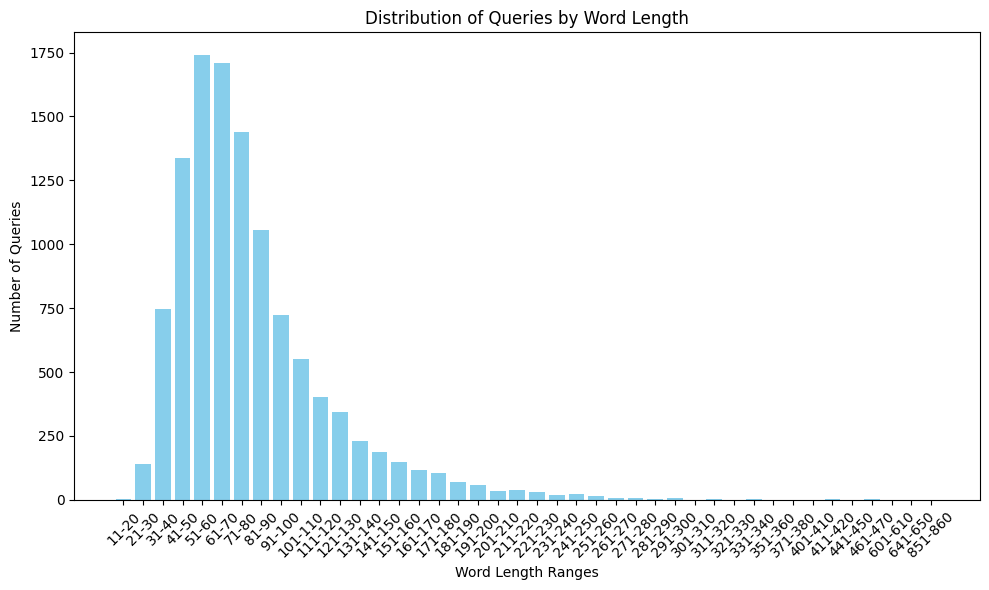

In [ ]:
def plot_bins_distribution(queries, bin_size=100):
    # Calculate the length of each query (in words)
    query_lengths = {qid: len(query) for qid, query in queries.items()}

    # Group queries by their length ranges
    bins = defaultdict(list)
    for qid, length in query_lengths.items():
        bin_range = (length - 1) // bin_size * bin_size + 1
        bins[bin_range].append(qid)

    # Prepare data for plotting
    bin_ranges = []
    query_counts = []
    for bin_range, qids in sorted(bins.items()):
        bin_end = bin_range + bin_size - 1
        bin_label = f"{bin_range}-{bin_end}"
        bin_ranges.append(bin_label)
        query_counts.append(len(qids))

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bin_ranges, query_counts, color='skyblue')
    plt.xlabel('Word Length Ranges')
    plt.ylabel('Number of Queries')
    plt.title('Distribution of Queries by Word Length')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_bins_distribution(queries, bin_size=10)

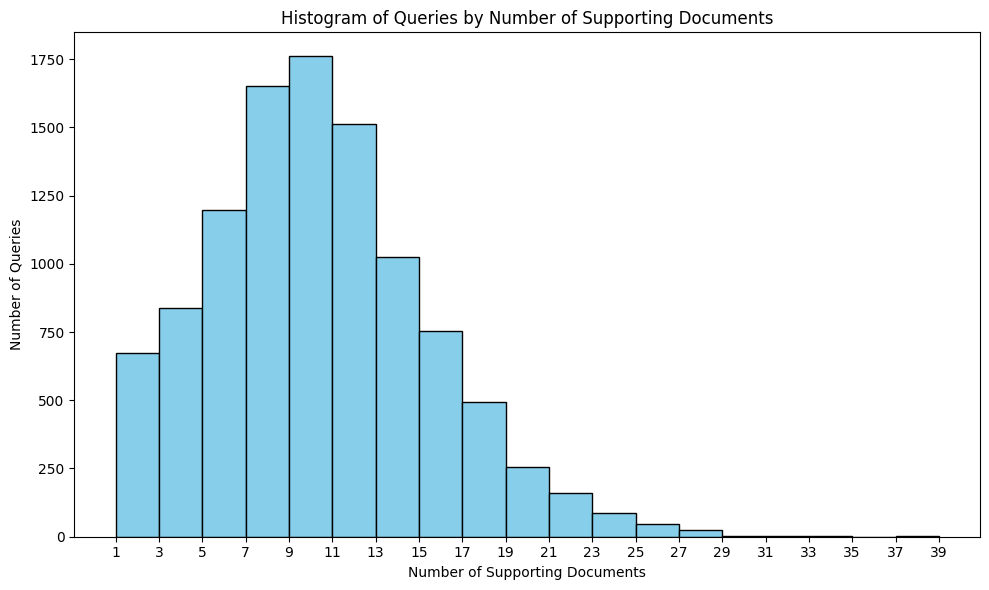

In [ ]:

def plot_queries_histogram_by_supporting_docs(queries, qrels, bin_size=1):
    """
    Plots a histogram of all queries based on the number of supporting documents each query has,
    with an option to specify the bin size.

    Parameters:
    - queries (dict): A dictionary of query_id to query text.
    - qrels (dict): A dictionary where keys are query_ids and values are lists of supporting document ids.
    - bin_size (int): The size of each bin in the histogram.

    Returns:
    - None: The function displays a histogram.
    """
    # Calculate the number of supporting documents for each query
    supporting_docs_counts = [len(qrels[query_id]) for query_id in queries.keys() if query_id in qrels]

    # Define the bins based on the bin size
    max_docs = max(supporting_docs_counts)
    bins = range(1, max_docs + bin_size + 1, bin_size)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(supporting_docs_counts, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Supporting Documents')
    plt.ylabel('Number of Queries')
    plt.title('Histogram of Queries by Number of Supporting Documents')
    plt.xticks(bins)
    plt.tight_layout()
    plt.show()

plot_queries_histogram_by_supporting_docs(queries, qrels, bin_size=2)


In [ ]:
test_queries = list(queries.values())
scores = []
for query in test_queries:
    score = calculate_linguistic_complexity(query)
    scores.append(score)

    #### print how many queries of each score (rounded to nearest whole number)

rounded_scores = [round(score) for score in scores]
# print(rounded_scores)

# from collections import Counter

# # Count the frequency of each rounded score
score_counts = Counter(rounded_scores)

print(score_counts)

# # Print the counts of each score
# for score, count in score_counts:
#     print(f"Complexity Score: {score}, Count: {count}")



Counter({8: 2022, 9: 1666, 7: 1577, 6: 1531, 10: 1178, 11: 841, 5: 794, 4: 513, 12: 512, 13: 250, 3: 140, 14: 135, 15: 62, 16: 28, 1: 19, 2: 14, 17: 12, 0: 7, -1: 4, 18: 3, 19: 3, 21: 1, 23: 1})
